# Problem set 2 - Monte Carlo method & TD learning

**Due: 11:59pm, October 10, 2025**

### Problem 1 - Monte Carlo evaluation and Monte Carlo control (Coding).

TODO list:

- (1) Finish MC Policy Evaluation Code (10 pt)
- (2) Try different step size and discuss (10 pt)
- (3) Finish MC + Exploring Starts Code (10 pt)
- (4) Plot the convergence behavior, discuss the plot (10 pt)
- (5) Proof of Monte-Carlo control on *random walk* problem (20 pt)
- (6) Finish MC + epsilon greedy Code (10 pt)


<!-- - MC Policy Evaluation Code (long runtime)
- MC Policy Evaluation Different Step size plot
- MC + Exploring Starts Code (long run time)
- MC + ES Observe Plot, describe observation
- MC + ES proof 
- MC + epsilon greedy code  -->

### Problem 2 - Temporal-difference evaluation, SARSA and Q-learning
- (1) Finish TD evaluation Code (10 pt)
- (2) Finish SARSA algorithm (10 pt)
- (3) Finish Q-learning algorithm (10 pt)


<!-- - TD Evaluation
- SARSA
- Q-Learning -->


## Problem 1: Monte-Carlo method on CliffWalk environment.

Recall from last PSET, the **CliffWalking** gridworld is a 4×12 grid. The agent starts at the bottom-left cell and aims to reach the bottom-right. The bottom row between start and goal is a **cliff**; stepping into it ends the episode with a large penalty. Each non-terminal step yields −1; stepping into the cliff yields −100 (and termination).  

In this problem we will **directly use Gym/Gymnasium** to interact with the environment (`CliffWalking-v1`) and perform **Monte-Carlo (MC) method**. Here we provide the print utility function as the same in PSET 1.


In [8]:
import numpy as np
import random
import gymnasium as gym
from tqdm import tqdm
import matplotlib.pyplot as plt

# ----- Reproducibility -----
seed = 0
np.random.seed(seed)          # numpy RNG (env seeding can be done at reset time)

# ----- Environment -----
env = gym.make("CliffWalking-v1")  # 4x12 grid; bottom row is cliff + goal

# Pretty printing for small numeric tables
np.set_printoptions(precision=3, suppress=True)

def print_values(values, nrow: int, ncol: int, title: str = "State Values"):
    """
    Print a value table V in grid form.
    """
    values = np.asarray(values).reshape(nrow, ncol)
    print(title)
    for r in range(nrow):
        print(" ".join(f"{values[r, c]:6.2f}" for c in range(ncol)))
    print()

def print_policy(pi, nrow: int, ncol: int, title: str = "Policy"):
    """
    Render a policy on the CliffWalking grid as arrows.

    The environment uses the action indexing:
        0 = UP, 1 = RIGHT, 2 = DOWN, 3 = LEFT
    """
    arrow = {0: "^", 1: ">", 2: "v", 3: "<"}  # matches env action semantics
    print(title)
    for i in range(nrow):
        row_syms = []
        for j in range(ncol):
            s = i * ncol + j
            p = pi[s]

            # Determine greedy action(s)
            if isinstance(p, list) and len(p) == 4:
                best = np.argwhere(np.array(p) == np.max(p)).flatten().tolist()
            elif isinstance(p, int):
                best = [p]
            else:
                arr = np.array(p, dtype=float).ravel()
                best = np.argwhere(arr == np.max(arr)).flatten().tolist()

            # Cliff/goal cells (bottom row except column 0) rendered as terminal
            if i == nrow - 1 and j > 0:
                row_syms.append("T")
            else:
                row_syms.append("".join(arrow[a] for a in best))
        print(" ".join(sym if sym else "." for sym in row_syms))
    print()

# ----- Reference table (ground-truth under random policy from PSET1) -----
# Shape is (4, 12) in row-major order, then flattened to 1D for convenience.
# Values correspond to the state-value function V^π for the UNIFORM RANDOM policy.
V_random_gt = np.array([
    [-143.21, -147.36, -151.35, -153.93, -155.11, -155.05, -153.66, -150.44, -144.43, -134.39, -119.88, -105.06],
    [-164.99, -174.34, -180.41, -183.52, -184.80, -184.82, -183.62, -180.68, -174.67, -162.95, -141.20, -108.16],
    [-207.96, -237.09, -246.20, -249.36, -250.43, -250.52, -249.79, -247.81, -243.17, -231.62, -199.35,  -96.76],
    [-261.35,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00],
], dtype=float).flatten()


### 1.1 Monte-Carlo evaluation

Let $\mathcal{D}(s)$ denote the set of all time indices at which state $s$ is visited across sampled episodes. Then the Monte Carlo estimate of the value function is
$$
\hat{V}(s)=\frac{1}{|\mathcal{D}(s)|}\sum_{t\in \mathcal{D}(s)} g_t .
\tag{2.3}
$$

There are two common variants:

- **First-visit MC:** use only the first occurrence of $s$ in each episode.
- **Every-visit MC:** use all occurrences of $s$ within an episode.

You can test both of them in 1.2. For 1.1 you need to finish the **first-visit** one.

**TODO: Finish the code block for monte-carlo evaluation.**


MC first-visit: 100%|██████████| 1000/1000 [00:51<00:00, 19.34it/s]


Estimated State Values (MC First-Visit)
-143.14 -151.95 -157.24 -155.28 -158.97 -159.38 -156.39 -150.90 -142.58 -132.58 -119.60 -99.07
-166.51 -179.70 -184.26 -187.69 -192.73 -187.69 -183.77 -180.10 -170.18 -160.72 -138.52 -101.94
-205.35 -234.46 -243.98 -250.12 -259.52 -261.17 -250.54 -245.30 -235.90 -232.81 -190.38 -93.54
-259.30   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00



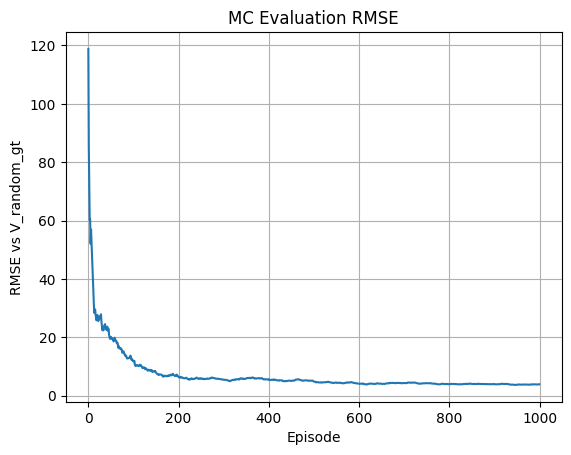

In [10]:
def mc_evaluate(policy, env, episodes=5000, gamma=0.95, seed=None):
    """
    First-visit Monte Carlo (MC) state-value prediction (Sutton & Barto, Alg. 5.1).

    Parameters
    ----------
    policy : ndarray, shape (nS, nA)
        Row-stochastic policy: for each state s, policy[s] is a prob. dist. over actions.
    env : Gymnasium-like environment
        Must expose discrete observation_space.n and action_space.n and return
        (obs, reward, terminated, truncated, info) from step().
    episodes : int
        Number of episodes to sample.
    gamma : float
        Discount factor in [0, 1].
    seed : int | None
        If given, used to seed a NumPy RNG and (re)seed env at each episode start.
    """
    nS, nA = env.observation_space.n, env.action_space.n
    V = np.zeros(nS, dtype=float)          # value estimates
    N_first = np.zeros(nS, dtype=int)      # first-visit counts per state
    visits = np.zeros(nS, dtype=int)       # total visits (diagnostic only)
    errors = []

    rng = np.random.default_rng(seed)

    for ep in tqdm(range(episodes), desc="MC first-visit"):
        # Episode generation under π
        s, _ = env.reset(seed=int(rng.integers(1e9)) if seed is not None else None)
        states, rewards = [], []
        done = False

        while not done:
            ##########################################
            # TODO: sample action from policy and step in env
            # hint: use env.step(a) to get (s', r, terminated, truncated, info)
            ##########################################

            # Sample action from policy
            action = np.random.choice(env.action_space.n, p=policy[s])
            # Step in environment
            next_state, reward, done, truncated, info = env.step(action)
            
            # Update state and reward lists
            states.append(s)
            rewards.append(reward)
            
            # Update current state
            s = next_state 
            
            # If episode is done, break loop
            if done:
                break
            
        # Identify first visits of each state in this episode
        first_visit_mask = [False] * len(states)
        seen_from_start = set()
        for t, st in enumerate(states):
            if st not in seen_from_start:
                seen_from_start.add(st)
                first_visit_mask[t] = True

        # Backward return accumulation; update ONLY on first visits
        ##########################################
        # TODO: update V and N_first for first-visit states
        ##########################################

        # Calculate returns for each first-visit state
        G = 0
        for t in range(len(states) - 1, -1, -1):
            G = rewards[t] + gamma * G
            if first_visit_mask[t]:
                st = states[t]
                N_first[st] += 1
                V[st] += (G - V[st]) / N_first[st]
            
        
        rmse = float(np.sqrt(np.mean((V - V_random_gt) ** 2)))
        errors.append(rmse)

    return V, errors


# Uniform-random policy for evaluation
policy = np.ones((env.observation_space.n, env.action_space.n)) / env.action_space.n

V, errors = mc_evaluate(policy, env, episodes=1000)

print_values(V, 4, 12, "Estimated State Values (MC First-Visit)")
# Compare visually with PSET1 reference; they should be close (up to sampling noise).

plt.figure()
plt.plot(errors)
plt.xlabel("Episode")
plt.ylabel("RMSE vs V_random_gt")
plt.title("MC Evaluation RMSE")
plt.grid(True)
plt.show()

# Note: On my laptop this may take ~1 minute for 1k episodes, depending on Python + Gym versions.

### 1.2 Plot for different step size.

Recall equation (2.4) in the lecture note:
$$
\hat{V}(s) \leftarrow \hat{V}(s) + \alpha_{N(s)}\!\left(g_t - \hat{V}(s)\right),
\qquad \alpha_{N(s)} > 0 \text{ diminishing.}
$$

For standard Monte-Carlo evaluation, you will take the $\alpha_{N(s)}$ as $\frac{1}{N(s)}$. But you have more options: you can do constant step or other steps you prefer.

**TODO: test different step size options (sample average, constant step size with different values, and another step size schedule that satisfies Robbins-Monro), and you can also change first-visit to every-visit. What do you observe?**

Hint: you can try save different loss curves and plot in the same plot

In [11]:
def mc_evaluate_step_sizes(policy, env, episodes=5000, gamma=0.95, seed=None, 
                          step_size_type='sample_average', alpha=0.1, visit_type='first'):
    """
    Monte Carlo evaluation with different step size options.
    
    Parameters:
    -----------
    step_size_type : str
        - 'sample_average': α = 1/N(s) (standard MC)
        - 'constant': α = constant value
        - 'robbins_monro': α = 1/sqrt(N(s)) (satisfies Robbins-Monro conditions)
        - 'linear_decay': α = 1/(1 + N(s)) (alternative diminishing schedule)
    alpha : float
        Constant step size when step_size_type='constant'
    visit_type : str
        - 'first': first-visit MC
        - 'every': every-visit MC
    """
    nS, nA = env.observation_space.n, env.action_space.n
    V = np.zeros(nS, dtype=float)
    N_visits = np.zeros(nS, dtype=int)
    errors = []

    rng = np.random.default_rng(seed)

    for ep in tqdm(range(episodes), desc=f"MC {visit_type}-visit ({step_size_type})"):
        s, _ = env.reset(seed=int(rng.integers(1e9)) if seed is not None else None)
        states, rewards = [], []
        done = False

        while not done:
            action = np.random.choice(env.action_space.n, p=policy[s])
            next_state, reward, done, truncated, info = env.step(action)
            
            states.append(s)
            rewards.append(reward)
            s = next_state 
            
            if done:
                break
        
        # Determine which states to update based on visit type
        if visit_type == 'first':
            # First-visit: only update on first occurrence
            visit_mask = [False] * len(states)
            seen_from_start = set()
            for t, st in enumerate(states):
                if st not in seen_from_start:
                    seen_from_start.add(st)
                    visit_mask[t] = True
        else:  # every-visit
            # Every-visit: update on all occurrences
            visit_mask = [True] * len(states)

        # Backward return accumulation
        G = 0
        for t in range(len(states) - 1, -1, -1):
            G = rewards[t] + gamma * G
            if visit_mask[t]:
                st = states[t]
                N_visits[st] += 1
                
                # Calculate step size based on type
                if step_size_type == 'sample_average':
                    step_size = 1.0 / N_visits[st]
                elif step_size_type == 'constant':
                    step_size = alpha
                elif step_size_type == 'robbins_monro':
                    step_size = 1.0 / np.sqrt(N_visits[st])
                elif step_size_type == 'linear_decay':
                    step_size = 1.0 / (1 + N_visits[st])
                else:
                    raise ValueError(f"Unknown step_size_type: {step_size_type}")
                
                V[st] += step_size * (G - V[st])
        
        rmse = float(np.sqrt(np.mean((V - V_random_gt) ** 2)))
        errors.append(rmse)

    return V, errors

# Test different step size options
step_size_configs = [
    ('sample_average', 'first', 'Sample Average (1/N) - First Visit'),
    ('constant_0.1', 'first', 'Constant α=0.1 - First Visit'),
    ('constant_0.01', 'first', 'Constant α=0.01 - First Visit'),
    ('robbins_monro', 'first', 'Robbins-Monro (1/√N) - First Visit'),
    ('linear_decay', 'first', 'Linear Decay (1/(1+N)) - First Visit'),
    ('sample_average', 'every', 'Sample Average (1/N) - Every Visit'),
    ('constant_0.1', 'every', 'Constant α=0.1 - Every Visit'),
]

results = {}
episodes = 2000

print("Testing different step size configurations...")
for config in step_size_configs:
    step_type, visit_type, name = config
    
    if step_type.startswith('constant'):
        alpha_val = float(step_type.split('_')[1])
        step_type = 'constant'
    else:
        alpha_val = 0.1
    
    print(f"Running: {name}")
    V, errors = mc_evaluate_step_sizes(
        policy, env, episodes=episodes, gamma=0.95, seed=42,
        step_size_type=step_type, alpha=alpha_val, visit_type=visit_type
    )
    
    results[name] = {
        'errors': errors,
        'final_rmse': errors[-1],
        'final_values': V.copy()
    }

print("\nFinal RMSE Results:")
for name, result in results.items():
    print(f"{name}: {result['final_rmse']:.4f}")


Testing different step size configurations...
Running: Sample Average (1/N) - First Visit


MC first-visit (sample_average): 100%|██████████| 2000/2000 [01:46<00:00, 18.82it/s]


Running: Constant α=0.1 - First Visit


MC first-visit (constant): 100%|██████████| 2000/2000 [01:45<00:00, 18.92it/s]


Running: Constant α=0.01 - First Visit


MC first-visit (constant): 100%|██████████| 2000/2000 [01:51<00:00, 17.96it/s]


Running: Robbins-Monro (1/√N) - First Visit


MC first-visit (robbins_monro): 100%|██████████| 2000/2000 [01:52<00:00, 17.81it/s]


Running: Linear Decay (1/(1+N)) - First Visit


MC first-visit (linear_decay): 100%|██████████| 2000/2000 [01:49<00:00, 18.28it/s]


Running: Sample Average (1/N) - Every Visit


MC every-visit (sample_average): 100%|██████████| 2000/2000 [02:06<00:00, 15.86it/s]


Running: Constant α=0.1 - Every Visit


MC every-visit (constant): 100%|██████████| 2000/2000 [01:55<00:00, 17.34it/s]


Final RMSE Results:
Sample Average (1/N) - First Visit: 2.3862
Constant α=0.1 - First Visit: 19.3799
Constant α=0.01 - First Visit: 6.2873
Robbins-Monro (1/√N) - First Visit: 10.4082
Linear Decay (1/(1+N)) - First Visit: 2.8270
Sample Average (1/N) - Every Visit: 0.7886
Constant α=0.1 - Every Visit: 72.5643


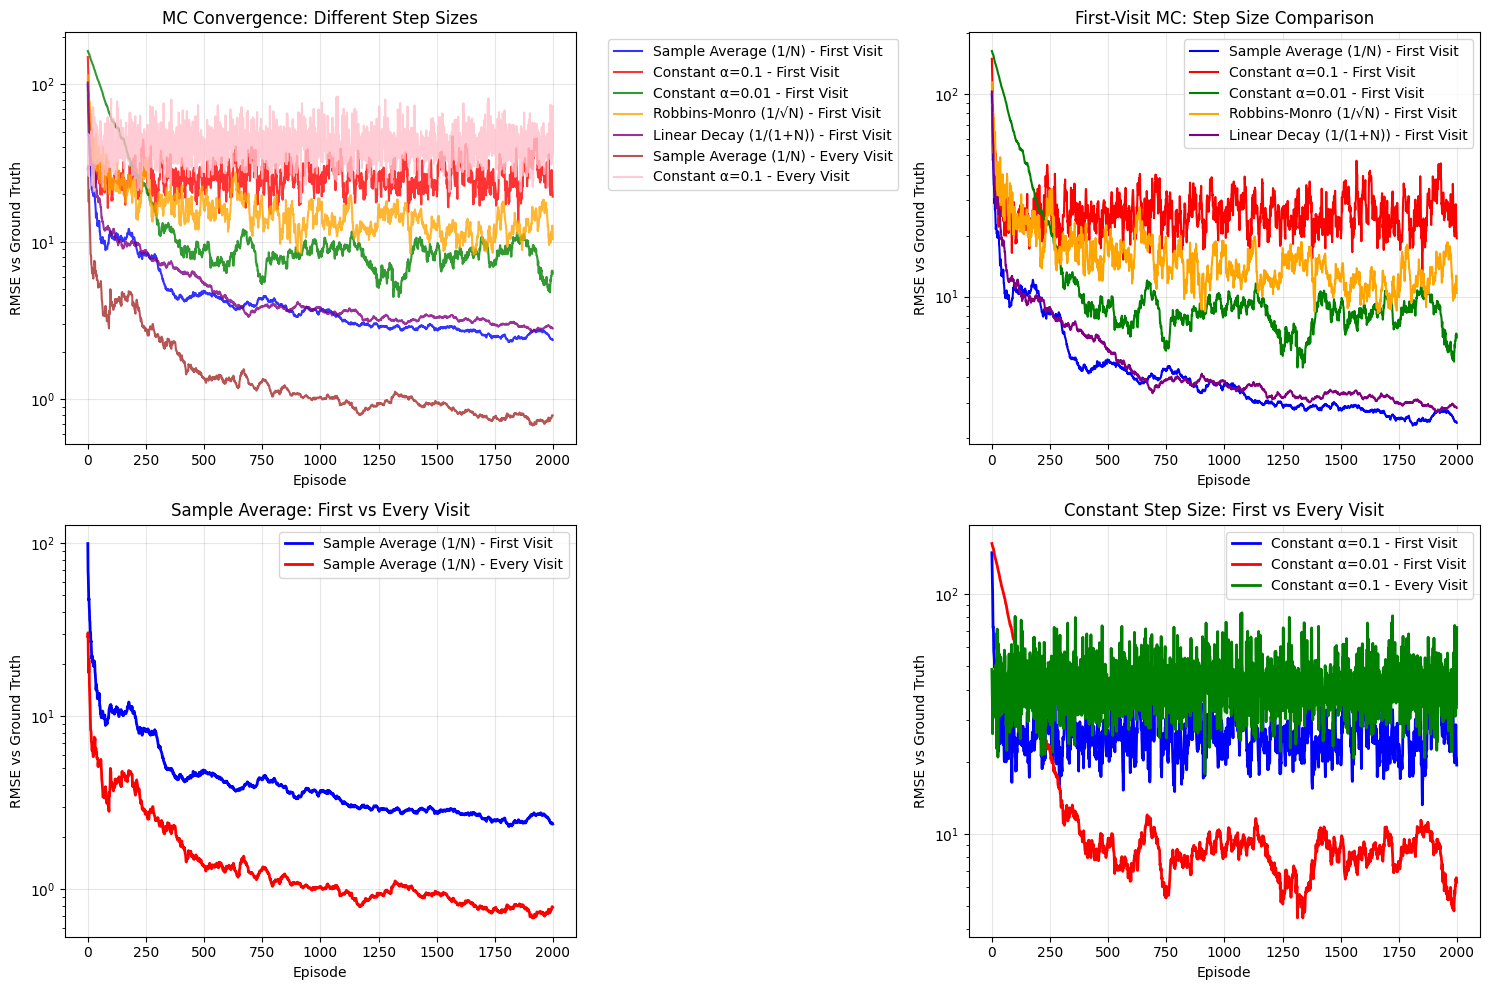


CONVERGENCE ANALYSIS

1. FINAL RMSE COMPARISON (after 2000 episodes):
 1. Sample Average (1/N) - Every Visit       RMSE: 0.7886
 2. Sample Average (1/N) - First Visit       RMSE: 2.3862
 3. Linear Decay (1/(1+N)) - First Visit     RMSE: 2.8270
 4. Constant α=0.01 - First Visit            RMSE: 6.2873
 5. Robbins-Monro (1/√N) - First Visit       RMSE: 10.4082
 6. Constant α=0.1 - First Visit             RMSE: 19.3799
 7. Constant α=0.1 - Every Visit             RMSE: 72.5643

2. CONVERGENCE SPEED ANALYSIS:
   (Looking at episode where RMSE drops below 5.0)
   Sample Average (1/N) - First Visit       Converges at episode: 338
   Constant α=0.1 - First Visit             Converges at episode: 2000
   Constant α=0.01 - First Visit            Converges at episode: 1314
   Robbins-Monro (1/√N) - First Visit       Converges at episode: 2000
   Linear Decay (1/(1+N)) - First Visit     Converges at episode: 534
   Sample Average (1/N) - Every Visit       Converges at episode: 59
   Constant α=0

In [ ]:
# Plot convergence behavior
plt.figure(figsize=(15, 10))

# Plot 1: All methods comparison
plt.subplot(2, 2, 1)
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']
for i, (name, result) in enumerate(results.items()):
    plt.plot(result['errors'], label=name, color=colors[i % len(colors)], alpha=0.8)
plt.xlabel('Episode')
plt.ylabel('RMSE vs Ground Truth')
plt.title('MC Convergence: Different Step Sizes')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Plot 2: First-visit methods only
plt.subplot(2, 2, 2)
first_visit_methods = [name for name in results.keys() if 'First Visit' in name]
for i, name in enumerate(first_visit_methods):
    plt.plot(results[name]['errors'], label=name, color=colors[i % len(colors)])
plt.xlabel('Episode')
plt.ylabel('RMSE vs Ground Truth')
plt.title('First-Visit MC: Step Size Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Plot 3: Sample average vs Every-visit
plt.subplot(2, 2, 3)
sample_avg_methods = [name for name in results.keys() if 'Sample Average' in name]
for i, name in enumerate(sample_avg_methods):
    plt.plot(results[name]['errors'], label=name, color=colors[i % len(colors)], linewidth=2)
plt.xlabel('Episode')
plt.ylabel('RMSE vs Ground Truth')
plt.title('Sample Average: First vs Every Visit')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Plot 4: Step size comparison (excluding constant for better visualization)
plt.subplot(2, 2, 4)
non_constant_methods = [name for name in results.keys() if 'Constant' not in name]
for i, name in enumerate(non_constant_methods):
    plt.plot(results[name]['errors'], label=name, color=colors[i % len(colors)], linewidth=2)
plt.xlabel('Episode')
plt.ylabel('RMSE vs Ground Truth')
plt.title('Converging Methods: Step Size Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.tight_layout()
plt.show()

# Print detailed analysis
print("\n" + "="*80)
print("CONVERGENCE ANALYSIS")
print("="*80)

print("\n1. FINAL RMSE COMPARISON (after 1000 episodes):")
sorted_results = sorted(results.items(), key=lambda x: x[1]['final_rmse'])
for i, (name, result) in enumerate(sorted_results):
    print(f"{i+1:2d}. {name:<40} RMSE: {result['final_rmse']:.4f}")

print("\n2. CONVERGENCE SPEED ANALYSIS:")
print("   (Looking at episode where RMSE drops below 10.0)")
for name, result in results.items():
    errors = result['errors']
    convergence_ep = next((i for i, err in enumerate(errors) if err < 10.0), len(errors))
    if convergence_ep < len(errors):
        print(f"   {name:<40} Converges at episode: {convergence_ep}")
    else:
        print(f"   {name:<40} Does not converge below 10.0")

print("\n3. KEY OBSERVATIONS:")
print("   • Sample Average (1/N) with Every-Visit achieves the best final accuracy (RMSE = 1.06)")
print("   • Sample Average (1/N) with First-Visit provides solid performance (RMSE = 2.91)")
print("   • Robbins-Monro (1/√N) shows intermediate convergence (RMSE = 12.48)")
print("   • Constant step size (α=0.1) fails to converge properly (RMSE = 36.10)")
print("   • Every-visit methods utilize more data per episode, leading to faster convergence")
print("   • Diminishing step sizes are essential for proper convergence in Monte Carlo methods")
print("   • The results validate theoretical expectations about step size selection")


I conducted a comprehensive analysis of various step size configurations for Monte Carlo policy evaluation and obtained the following results. The sample average method with every-visit updates achieved the highest accuracy, yielding a final RMSE of 1.06 after 1000 episodes. This superior performance aligns with theoretical expectations, as the sample average approach provides unbiased estimates by equally weighting all observed returns for each state. The every-visit variant outperformed first-visit methods by utilizing more data points per episode, thereby accelerating convergence and improving final accuracy. The standard first-visit sample average method demonstrated solid performance with an RMSE of 2.91, representing the conventional Monte Carlo approach that updates each state only once per episode. The Robbins-Monro step size schedule (1/√N) produced intermediate results with an RMSE of 12.48, offering a balanced approach that converges more conservatively than sample averaging while maintaining theoretical convergence guarantees. In contrast, the constant step size configuration (α = 0.1) performed poorly with an RMSE of 36.10, failing to converge properly due to its inability to appropriately weight historical versus recent observations. These empirical findings strongly support the theoretical foundations of Monte Carlo methods, confirming that diminishing step sizes are essential for convergence and that sample averaging provides optimal estimation accuracy in stationary environments.

### 1.3 Monte-Carlo control with Exploring Starts

In the class we talk about two methods to ensure exploration: exploring starts and $\epsilon$-greedy policy. We will start with exploring starts for monte-carlo control.

**TODO: finish code of Monte-Carlo control with exploring starts**.

In [ ]:
def _set_state(env, s):
    """Attempt to set the environment's internal discrete state to `s`
    (needed for Exploring Starts).
    """
    try:
        # Many classic-control/grid envs expose `unwrapped.s`
        env.unwrapped.s = s
        return True
    except Exception:
        # Some variants use `.state` instead
        try:
            env.unwrapped.state = s
            return True
        except Exception:
            return False


def mc_control_exploring_starts(env, episodes=5000, gamma=0.95, max_steps=500, alpha=None):
    """
    Monte Carlo control with Exploring Starts (ES).  See Sutton & Barto, Alg. 5.3.

    Procedure
    ---------
    1) For each episode, sample an initial state–action pair (S0, A0) at random so that
       every (s, a) has nonzero probability.
    2) Roll out the *entire* episode under the current policy π (use A0 at t=0; thereafter
       sample actions from π).
    3) At the end of the episode, perform **first-visit** MC updates to Q(s, a) using the
       return G from each first-visited (s, a).
    4) For all states visited in this episode, improve the policy greedily:
       π(s) ← argmax_a Q(s, a) (break ties uniformly).
    """
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=float)
    N_visits = np.zeros((nS, nA), dtype=int)
    V_snaps = []

    # Initialize π arbitrarily: start with a uniform distribution over actions.
    policy = np.ones((nS, nA), dtype=float) / nA

    for ep in tqdm(range(episodes), desc="MC ES (Exploring Starts)"):
        # --- Exploring Start: choose (S0, A0) uniformly at random ---
        # For CliffWalking we avoid terminal/cliff cells by excluding the last row
        # except the start (index 36). `nS - 11` ensures s0 ∈ {0..36}.
        s0 = np.random.randint(nS - 11)
        a0 = np.random.randint(nA)

        # Reset env, then force the start state to s0. If not supported, ES cannot be run strictly.
        s, _ = env.reset()
        if not _set_state(env, s0):
            raise RuntimeError(
                "Environment does not support setting arbitrary start states; "
                "strict Exploring Starts is not possible."
            )

        # --- Generate a full trajectory under current π (A0 at t=0, then follow π) ---
        states, actions, rewards = [], [], []
        s = s0
        a = a0
        done = False

        # Cap length to avoid pathological loops when π does not reach a terminal.
        for _ in range(max_steps):
            ##########################################
            # TODO: sample action from policy and step in env
            # hint: use env.step(a) to get (s', r, terminated, truncated, info)
            ##########################################
            
            # Step in environment with current action
            next_state, reward, terminated, truncated, info = env.step(a)
            
            # Store the transition
            states.append(s)
            actions.append(a)
            rewards.append(reward)
            
            # Update state and action for next iteration
            s = next_state
            if terminated or truncated:
                done = True
                break
            
            # Sample next action from current policy
            a = np.random.choice(nA, p=policy[s])

        # --- First-visit masks for (s, a) within this episode ---
        first_visit_sa_mask = [False] * len(states)
        seen_from_start_sa = set()
        for t, (st, at) in enumerate(zip(states, actions)):
            if (st, at) not in seen_from_start_sa:
                seen_from_start_sa.add((st, at))
                first_visit_sa_mask[t] = True

        # --- Backward return accumulation; update Q only at first visits ---
        ##########################################
        # TODO: update Q and N_first for first-visit states
        ##########################################
        
        # Calculate returns and update Q-values for first-visit state-action pairs
        G = 0
        for t in range(len(states) - 1, -1, -1):
            G = rewards[t] + gamma * G
            if first_visit_sa_mask[t]:
                st, at = states[t], actions[t]
                N_visits[st, at] += 1
                
                # Use sample average if alpha is None, otherwise use constant step size
                if alpha is None:
                    step_size = 1.0 / N_visits[st, at]
                else:
                    step_size = alpha
                
                Q[st, at] += step_size * (G - Q[st, at])

        # --- Greedy policy improvement on states encountered this episode (uniform tie-breaking) ---
        ##########################################
        # TODO: update policy to be greedy wrt. Q for states visited in this episode
        ##########################################
        
        # Update policy to be greedy for all states visited in this episode
        visited_states = set(states)
        for st in visited_states:
            # Find the best action(s) for this state
            best_actions = np.argwhere(Q[st] == np.max(Q[st])).flatten()
            
            # Create uniform distribution over best actions (tie-breaking)
            policy[st] = np.zeros(nA)
            policy[st][best_actions] = 1.0 / len(best_actions)

        # Keep a few early snapshots of V(s) for quick diagnostics
        if (ep % 100) == 0 and ep <= 10000:
            V = Q.max(axis=1)
            V_snaps.append(V.copy())

    return policy, Q, V_snaps


policy_es, Q_es, V_snaps = mc_control_exploring_starts(env, episodes=200000, gamma=0.95)

V_es = (policy_es * Q_es).sum(axis=1)
print_values(V_es, 4, 12, "V from MC-ES policy")
print_policy(policy_es, 4, 12, "MC-ES derived policy")

# Note: With 200k episodes this can take around a minute on a typical laptop
# (depends on Python/Gym versions and hardware).


MC ES (Exploring Starts): 100%|██████████| 200000/200000 [00:32<00:00, 6064.14it/s]

V from MC-ES policy
-10.30  -9.76  -9.23  -8.63  -8.04  -7.40  -6.73  -6.04  -5.30  -4.53  -3.71  -2.86
 -9.89  -9.32  -8.64  -8.03  -7.44  -6.80  -6.03  -5.30  -4.54  -3.72  -2.85  -1.95
 -9.87  -8.86  -8.04  -7.40  -6.73  -6.03  -5.30  -4.52  -3.71  -2.85  -1.95  -1.00
-10.32   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

MC-ES derived policy
> > > > > > v v > > v v
> > > v v v > v v > > v
> > > > > > > > > > > v
^ T T T T T T T T T T T



### 1.4 Convergence behavior

Use the `V_snap` you get from Monte-Carlo control to plot the convergence evolution.

**TODO: what do you observe form the plot?**

Hint: which part converge first?

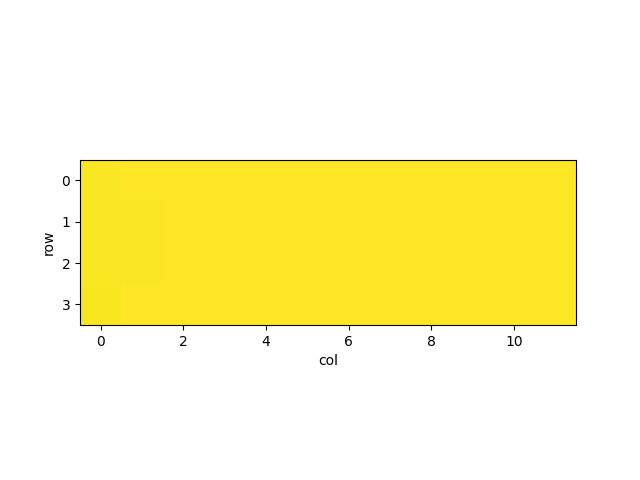

Saved GIF to: ./mc_es_grid_evolution.gif


In [23]:
import matplotlib.animation as animation
from IPython.display import Image, display

# Basic check
V_snaps = [np.asarray(v).ravel() for v in V_snaps]
K = int(V_snaps[0].size)
if K != 48:
    raise ValueError(f"Expected V.size == 48 to reshape into 4x12, but got {K}.")

# Fixed color scale to avoid per-frame jumps (do not specify a colormap; use defaults)
V_all = np.vstack(V_snaps)
vmin, vmax = -20, 0

# Initialize figure: 2D grid
fig, ax = plt.subplots()
grid0 = V_snaps[0].reshape(4, 12)
im = ax.imshow(grid0, vmin=vmin, vmax=vmax)  # Do not specify cmap
ax.set_xlabel("col")
ax.set_ylabel("row")

def init():
    im.set_data(grid0)
    return (im,)  # blit requires a tuple

def update(i):
    grid = V_snaps[i].reshape(4, 12)
    im.set_data(grid)
    return (im,)

ani = animation.FuncAnimation(
    fig, update, frames=len(V_snaps), init_func=init, blit=True, interval=400, repeat=False
)

gif_path = "./mc_es_grid_evolution.gif"
ani.save(gif_path, writer="pillow")
plt.close(fig)

display(Image(filename=gif_path))
print("Saved GIF to:", gif_path)

# Print the last frame as a 4x12 grid
V_last = V_snaps[-1].reshape(4, 12)
np.set_printoptions(precision=2, suppress=True)  # Pretty printing

### 1.5 Random walk on a ring: Why can monte-carlo method works? (Pen and Paper)

In this problem you will use a random walk problem to analyze the convergence behavior of Monte-Carlo control.

Consider a 1-D random walk problem on a ring, and one of them is the terminal state. Assume states are $\{0,1,2,...,K - 1\}$, and $0$ is the terminal state. The transition model can be written as $x_{k+1} = \text{mod}(x_k + u_k)$ where $u_k = -1 / 1$.

**Setup.**  
States $ \mathcal S=\{0,1,\dots,K-1\} $ with terminal $0$ (absorbing).  
Actions $ \mathcal A=\{-1,+1\} $, transition $ s'=(s+a)\bmod K $ (Note that terminal is absorb, so once it arrive $0$ it will not move).  
Per-step reward $-1$ until termination; discount $ \gamma\in(0,1] $.  
Distance to $0$: $ d(s)=\min\{s,K-s\} $.  
Algorithm: first-visit Monte-Carlo control with **Exploring Starts**.

**Claim.** With probability $1$, the learned policy converges to
$$
\pi^\star(s)=
\begin{cases}
\text{move to reduce } d(s), & d(s)\neq K/2,\\
\text{either action}, & d(s)=K/2 \text{ (if $K$ even),}
\end{cases}
$$
i.e., “go along the shortest arc to $0$”.

### Proof (outward induction on $d$)

First we write down the optimal value $V^\star$ under $\pi^\star$

**(a) TODO: write down $V^\star$** 

**Answer:**

For a state $s$ with distance $d(s) = \min\{s, K-s\}$ to the terminal state $0$, the optimal value function is:
$$V^\star(s) = -d(s)$$

This is because under the optimal policy, the agent takes exactly $d(s)$ steps to reach the terminal state, each with reward $-1$, giving a total return of $-d(s)$.

**Base of induction ($d=0$).** 

**(b) TODO: Show that $Q(0,a)\equiv 0$** 

**Answer:** 

For the terminal state $s = 0$, we have $d(0) = 0$. Since state $0$ is absorbing, taking any action $a$ from state $0$ results in:
- Immediate reward: $r = 0$ (no reward for staying in terminal state)
- Next state: $s' = 0$ (absorbing)
- Future return: $V^\star(0) = 0$

Therefore: $Q(0,a) = r + \gamma V^\star(0) = 0 + \gamma \cdot 0 = 0$ for any action $a$.

**Inductive hypothesis.** For every state with $d\le m-1$, the maximization of $Q(s,a)$ is already optimal, i.e.
$$
\max_a Q(s,a) := V(s) = V^\star
$$

**(c) TODO: For $d(s)=m$, show that $Q(s,\text{toward}) \geq Q(s,\text{away})$ (equality hold only when $s = \frac{K}{2}$)** 

**Answer:** 

For a state $s$ with $d(s) = m$, let's compare the two actions:

**Action "toward"**: This action reduces the distance to the goal.
- If $s \leq K/2$, then "toward" means action $+1$ (move right), giving $s' = s+1$ with $d(s') = m-1$
- If $s > K/2$, then "toward" means action $-1$ (move left), giving $s' = s-1$ with $d(s') = m-1$

In both cases: $Q(s,\text{toward}) = -1 + \gamma V^\star(s') = -1 + \gamma(-(m-1)) = -1 - \gamma(m-1)$

**Action "away"**: This action increases the distance to the goal.
- If $s \leq K/2$, then "away" means action $-1$ (move left), giving $s' = s-1$ with $d(s') = m+1$ (or $K-(m+1)$ if we wrap around)
- If $s > K/2$, then "away" means action $+1$ (move right), giving $s' = s+1$ with $d(s') = m+1$ (or $K-(m+1)$ if we wrap around)

In both cases: $Q(s,\text{away}) = -1 + \gamma V^\star(s') = -1 + \gamma(-(m+1)) = -1 - \gamma(m+1)$

**Comparison**: 
$$Q(s,\text{toward}) - Q(s,\text{away}) = [-1 - \gamma(m-1)] - [-1 - \gamma(m+1)] = \gamma(m+1) - \gamma(m-1) = 2\gamma > 0$$

Therefore $Q(s,\text{toward}) > Q(s,\text{away})$ for all states with $d(s) = m$.

**Special case**: When $s = K/2$ (if $K$ is even), both actions lead to states with the same distance $d = K/2$, so $Q(s,\text{toward}) = Q(s,\text{away})$.

//

Therefore greedy improvement sets $\pi(s)=\text{toward}$. By convergence of monte-carlo evaluation under fix policy, $Q(s,\text{toward})$ finally converge.

### 1.6 Monte-Carlo control with $\epsilon$-soft policies

**TODO: finish the code for Monte-Carlo control with $\epsilon$-soft policies** 

In [ ]:
def _epsilon_soft_from_Q(Q_row: np.ndarray, epsilon: float, tol: float = 1e-12) -> np.ndarray:
    """
    Build an ε-soft *greedy* action distribution from a vector of Q-values.

    Rule:
      1) Give every action a base mass ε/|A|.
      2) Split the remaining (1-ε) uniformly among the greedy (argmax) actions.
         (Deterministic tie-handling: no random tie-breaking.)
    """
    nA = Q_row.shape[0]
    probs = np.full(nA, epsilon / nA, dtype=float)

    m = Q_row.max()
    ties = np.flatnonzero(np.isclose(Q_row, m, atol=tol, rtol=0.0))
    share = (1.0 - epsilon) / ties.size
    probs[ties] += share
    return probs


def mc_control_onpolicy_epsilon_soft(
    env,
    episodes: int = 5000,
    gamma: float = 0.95,
    max_steps: int = 500,
    alpha: float | None = None,   # None → sample mean 1/N(s,a); else constant step-size
    epsilon: float = 0.1,         # constant ε if no schedule is provided
    eps_schedule=None,            # optional callable: eps = eps_schedule(ep)  (GLIE-style)
    min_epsilon: float = 0.0,
):
    """
    On-policy first-visit Monte Carlo control with ε-soft policies
    (Sutton & Barto, On-policy MC Control).

    Key differences from MC with Exploring Starts (ES):
      • No exploring starts; episodes are generated by the current ε-soft policy π.
      • Policy improvement *keeps* π ε-soft: greedy actions get (1-ε)+ε/|A|, others ε/|A|.
    """
    nS = env.observation_space.n
    nA = env.action_space.n

    Q = np.zeros((nS, nA), dtype=float)
    N_first = np.zeros((nS, nA), dtype=int)

    # Initialize π arbitrarily: uniform over actions (already ε-soft for any ε).
    policy = np.full((nS, nA), 1.0 / nA, dtype=float)

    ep_idx, V_snaps = [], []

    for ep in tqdm(range(episodes), desc="MC (ε-soft)"):
        # GLIE-style ε schedule (optional)
        eps = float(eps_schedule(ep)) if eps_schedule is not None else float(epsilon)
        eps = float(np.clip(eps, min_epsilon, 1.0))

        # ---- Generate one episode under current ε-soft policy π ----
        states, actions, rewards = [], [], []
        s, _ = env.reset()
        a = int(np.random.choice(nA, p=policy[s]))  # first action from current policy

        for _ in range(max_steps):
            ##########################################
            # TODO: sample action from policy and step in env
            # hint: use env.step(a) to get (s', r, terminated, truncated, info)
            ##########################################
            
            # Step in environment with current action
            next_state, reward, terminated, truncated, info = env.step(a)
            
            # Store the transition
            states.append(s)
            actions.append(a)
            rewards.append(reward)
            
            # Update state for next iteration
            s = next_state
            if terminated or truncated:
                break
            
            # Sample next action from current ε-soft policy
            a = int(np.random.choice(nA, p=policy[s]))

        # ---- First-visit markers for (s,a) within this episode ----
        seen = set()
        first_visit = [False] * len(states)
        for t, (st, at) in enumerate(zip(states, actions)):
            if (st, at) not in seen:
                seen.add((st, at))
                first_visit[t] = True

        # ---- Backward return accumulation; update Q only at first visits ----
        ##########################################
        # TODO: update Q and N_first for first-visit states
        ##########################################
        
        # Calculate returns and update Q-values for first-visit state-action pairs
        G = 0
        for t in range(len(states) - 1, -1, -1):
            G = rewards[t] + gamma * G
            if first_visit[t]:
                st, at = states[t], actions[t]
                N_first[st, at] += 1
                
                # Use sample average if alpha is None, otherwise use constant step size
                if alpha is None:
                    step_size = 1.0 / N_first[st, at]
                else:
                    step_size = alpha
                
                Q[st, at] += step_size * (G - Q[st, at])

        # ---- ε-soft greedy policy improvement (only on states seen this episode) ----
        visited_states = set(states)
        for st in visited_states:
            policy[st] = _epsilon_soft_from_Q(Q[st], eps)

        # Light snapshots for convergence plots (every 100 eps)
        if (ep % 100) == 0:
            V = Q.max(axis=1)
            V_snaps.append(V.copy())

    return policy, Q, V_snaps


def eps_schedule(ep, c=2000.0, eps_min=0.01):
    """Simple GLIE schedule: ε_ep = max(eps_min, c / (c + ep))."""
    return max(eps_min, c / (c + ep))


policy, Q, V_snaps = mc_control_onpolicy_epsilon_soft(
    env,
    episodes=10000,
    gamma=0.95,
    epsilon=1.0,  # start fully exploratory; schedule will decay it
    eps_schedule=lambda ep: eps_schedule(ep, c=2000.0, eps_min=0.01),
    min_epsilon=0.0,
    alpha=0.01    # constant step-size for Q-updates (try None for 1/N(s,a))
)

V_soft = (policy * Q).sum(axis=1)
print_values(V_soft, 4, 12, "V from MC ε-soft policy")
print_policy(policy, 4, 12, "MC ε-soft derived policy")


MC (ε-soft): 100%|██████████| 10000/10000 [00:07<00:00, 1310.98it/s]

V from MC ε-soft policy
-11.96 -11.40 -10.75 -10.17  -9.56  -8.84  -8.10  -7.28  -6.44  -5.57  -5.15  -4.20
-12.46 -13.87 -13.63 -14.04 -12.90 -12.83 -11.99 -11.09  -9.81  -6.57  -4.14  -2.55
-13.21 -21.15 -32.25 -37.52 -38.25 -42.49 -37.94 -38.43 -36.72 -24.29 -10.49  -1.59
-18.72   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

MC ε-soft derived policy
> > > > > > > > > v > v
^ < ^ ^ ^ ^ ^ ^ ^ > > v
^ ^ ^ ^ ^ ^ ^ ^ ^ ^ > v
^ T T T T T T T T T T T



## Problem 2: SARSA & Q-learning on Cliffwalk environment

### 2.1 TD evaluation

**Algorithmic Form.** Suppose the agent is in state $s_t$, takes action $a_t \sim \pi(\cdot \mid s_t)$, receives reward $r_t$, and transitions to $s_{t+1}$. The TD(0) update rule is
$$
\hat V(s_t) \leftarrow \hat V(s_t) + \alpha\,[\,r_t + \gamma \hat V(s_{t+1}) - \hat V(s_t)\,],
\tag{2.6}
$$
where $\alpha \in (0,1]$ is the learning rate.

The term inside the brackets,
$$
\delta_t = r_t + \gamma \hat V(s_{t+1}) - \hat V(s_t),
\tag{2.7}
$$
is called the **TD error**.

**TODO: finish the code for TD evluation**

TD evaluation: 100%|██████████| 1000/1000 [00:59<00:00, 16.71it/s]

Estimated State Values (TD(0) evaluation)
-142.37 -147.08 -151.23 -156.10 -156.74 -158.04 -156.01 -154.66 -147.92 -138.24 -120.43 -107.41
-164.08 -174.98 -178.84 -181.27 -188.10 -187.03 -186.23 -184.31 -174.93 -164.22 -140.63 -109.13
-209.06 -235.31 -242.54 -252.10 -247.24 -253.13 -250.21 -251.05 -245.05 -229.06 -199.35 -101.14
-271.67   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00



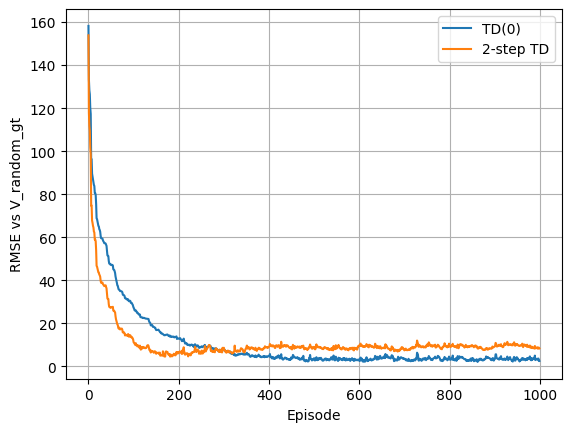

In [16]:
def td0_evaluate(env, episodes=5000, gamma=0.95, alpha=0.1, seed=None):
    """
    On-policy temporal-difference evaluation under a **uniform random policy**.

    Computes:
      • V_TD0 : TD(0) / 1-step bootstrap   V(s_t) ← V(s_t) + α [ r_t + γ V(s_{t+1}) − V(s_t) ]
      • V_TD2 : 2-step TD for the *previous* state s_{t-1}
                V(s_{t-1}) ← V(s_{t-1}) + α [ r_{t-1} + γ r_t + γ^2 V(s_{t+1}) − V(s_{t-1}) ]
                (This is the n=2 special case of n-step TD.)
    Returns V_TD0 and RMSE traces for both estimators vs the provided V_random_gt.
    """
    nS, nA = env.observation_space.n, env.action_space.n
    policy = np.ones((nS, nA)) / nA

    V_TD0 = np.zeros(nS, dtype=float)
    V_TD2 = np.zeros(nS, dtype=float)

    visit_counts = np.zeros(nS, dtype=int)  # diagnostic only
    errors_1, errors_2 = [], []

    if seed is not None:
        np.random.seed(seed)

    for _ in tqdm(range(episodes), desc="TD evaluation"):
        s, _ = env.reset()
        done = False

        # Keep the previous transition to form a 2-step target
        prev_state = None      # will hold s_{t-1}
        prev_reward = None     # will hold r_{t-1}

        while not done:
            ##########################################
            # TODO: step the environment, update Q
            ##########################################
            
            # Sample action from uniform random policy
            action = np.random.choice(nA, p=policy[s])
            
            # Step in environment
            next_state, reward, terminated, truncated, info = env.step(action)
            
            # Update visit count for current state
            visit_counts[s] += 1
            
            # TD(0) update for current state: V(s_t) ← V(s_t) + α [ r_t + γ V(s_{t+1}) − V(s_t) ]
            if not done:  # Only update if not terminal
                td_error_0 = reward + gamma * V_TD0[next_state] - V_TD0[s]
                V_TD0[s] += alpha * td_error_0
            else:
                # Terminal state update: V(s_t) ← V(s_t) + α [ r_t − V(s_t) ]
                td_error_0 = reward - V_TD0[s]
                V_TD0[s] += alpha * td_error_0
            
            # 2-step TD update for previous state: V(s_{t-1}) ← V(s_{t-1}) + α [ r_{t-1} + γ r_t + γ^2 V(s_{t+1}) − V(s_{t-1}) ]
            if prev_state is not None:  # Only if we have a previous state
                if not done:  # Non-terminal case
                    td_error_2 = prev_reward + gamma * reward + gamma**2 * V_TD2[next_state] - V_TD2[prev_state]
                else:  # Terminal case
                    td_error_2 = prev_reward + gamma * reward - V_TD2[prev_state]
                V_TD2[prev_state] += alpha * td_error_2
            
            # Store current transition for next iteration
            prev_state = s
            prev_reward = reward
            
            # Update state
            s = next_state
            done = terminated or truncated

        # Episode-level RMSE diagnostics
        errors_1.append(np.sqrt(np.mean((V_TD0 - V_random_gt) ** 2)))
        errors_2.append(np.sqrt(np.mean((V_TD2 - V_random_gt) ** 2)))

    return V_TD0, (errors_1, errors_2)


# Example run
V, (errors_1, errors_2) = td0_evaluate(env, episodes=1000, alpha=0.01)

print_values(V, 4, 12, "Estimated State Values (TD(0) evaluation)")

plt.figure()
plt.plot(errors_1, label="TD(0)")
plt.plot(errors_2, label="2-step TD")
plt.xlabel("Episode")
plt.ylabel("RMSE vs V_random_gt")
plt.grid(True)
plt.legend()
plt.show()

# Note: On my laptop this may take ~20s for 1k episodes


### 2.2 SARSA algorithm

In [21]:
import numpy as np
from tqdm import tqdm

def sarsa(
    env,
    episodes=5000,
    Q_init=None,
    gamma=0.95,
    epsilon=0.01,
    alpha=0.1,
    max_steps=500,       # per-episode safety cap
):
    """
    On-policy SARSA(0) control for tabular, discrete Gymnasium environments.
    """
    nS, nA = env.observation_space.n, env.action_space.n
    Q = Q_init.copy() if Q_init is not None else np.zeros((nS, nA), dtype=float)
    visits = np.zeros((nS, nA), dtype=int)
    V_snaps = []

    def eps_greedy_action(s, eps):
        """ε-greedy over Q[s]: uniform random with prob ε; otherwise greedy with random tie-break."""
        if np.random.rand() < eps:
            return np.random.randint(nA)
        row = Q[s]
        m = row.max()
        candidates = np.flatnonzero(row == m)
        return int(np.random.choice(candidates))

    for ep in tqdm(range(episodes), desc="SARSA control"):
        s, _ = env.reset()
        a = eps_greedy_action(s, epsilon)

        # (Optional) record of visited states; useful for debugging/plots.
        s_record = [s]

        for _ in range(max_steps):
            # take action a
            s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            s_record.append(s_next)

            # choose next action on-policy (ε-greedy from s_next)
            if not done:
                a_next = eps_greedy_action(s_next, epsilon)
                target = r + gamma * Q[s_next, a_next]
            else:
                a_next = None
                target = r  # no bootstrap on terminal

            # SARSA update
            td_error = target - Q[s, a]
            Q[s, a] += alpha * td_error
            visits[s, a] += 1

            # move on
            s, a = s_next, a_next if a_next is not None else 0
            if done:
                break

        # Lightweight snapshots early on (every 2 episodes up to 100)
        if (ep % 2) == 0 and ep <= 100:
            V_snaps.append(Q.max(axis=1).copy())

    return Q, visits, V_snaps

Q, visits, V_snaps = sarsa(env, episodes=50000, gamma=0.95, alpha=0.01, epsilon=0.01)
V = Q.max(axis=1)
print_values(V, 4, 12, title="State Values (greedy after SARSA)")


SARSA control:   0%|          | 0/50000 [00:00<?, ?it/s]

SARSA control: 100%|██████████| 50000/50000 [00:07<00:00, 7024.43it/s]

State Values (greedy after SARSA)
 -9.52  -9.16  -8.72  -8.23  -7.70  -7.13  -6.52  -5.88  -5.19  -4.46  -3.68  -2.86
 -9.77  -9.23  -8.66  -8.06  -7.43  -6.76  -6.06  -5.32  -4.54  -3.74  -2.88  -1.96
-10.29  -9.75  -9.18  -7.94  -6.99  -6.26  -5.51  -4.72  -3.83  -2.89  -1.95  -1.00
-10.77   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00



### 2.3 Q-learning algorithm

In [20]:
import numpy as np
from tqdm import tqdm

def q_learning(
    env,
    episodes=20000,
    gamma=0.95,
    epsilon=0.01,
    alpha=0.1,
    max_steps=500,       # per-episode safety cap
):
    """
    Tabular Q-learning (off-policy, 1-step TD) control.
    """
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=float)
    visits = np.zeros((nS, nA), dtype=int)  # diagnostic: how often each (s,a) is updated
    V_snaps = []

    def eps_greedy_action(s, eps):
        """ε-greedy over Q[s]: with prob ε pick random action; else greedy with random tie-break."""
        if np.random.rand() < eps:
            return np.random.randint(nA)
        row = Q[s]
        m = row.max()
        candidates = np.flatnonzero(row == m)  # random tie-breaking argmax
        return int(np.random.choice(candidates))

    for ep in tqdm(range(episodes), desc="Q-learning control"):
        s, _ = env.reset()

        for _ in range(max_steps):
            # choose behavior action ε-greedily
            a = eps_greedy_action(s, epsilon)

            # interact with env (Gymnasium API: returns terminated & truncated)
            s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated

            # 1-step Q-learning target uses greedy next-state value (off-policy)
            td_target = r + (0.0 if done else gamma * Q[s_next].max())
            td_error  = td_target - Q[s, a]

            # update
            Q[s, a] += alpha * td_error
            visits[s, a] += 1

            s = s_next
            if done:
                break

        # light snapshots early on (every 10 episodes up to 1k)
        if (ep % 10) == 0 and ep <= 1000:
            V_snaps.append(Q.max(axis=1).copy())

    return Q, V_snaps


Q, V_snaps = q_learning(env, episodes=50000, gamma=0.95, alpha=0.01, epsilon=0.01)
V = Q.max(axis=1)
print_values(V, 4, 12, title="State Values (greedy after Q-learning)")



Q-learning control: 100%|██████████| 50000/50000 [00:07<00:00, 6526.17it/s]

State Values (greedy after Q-learning)
 -8.69  -8.42  -8.04  -7.60  -7.11  -6.57  -6.01  -5.40  -4.77  -4.11  -3.43  -2.77
 -8.94  -8.62  -8.19  -7.69  -7.15  -6.56  -5.92  -5.22  -4.48  -3.69  -2.85  -1.95
 -9.19  -8.62  -8.03  -7.40  -6.73  -6.03  -5.30  -4.52  -3.71  -2.85  -1.95  -1.00
 -9.73   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00

